In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

#import iceplant_detection_functions as ipf
#import model_prep_and_evals as mpe

import warnings
import time

##  Initialize Dask

In [2]:
import dask
from dask.distributed import Client

client = Client()  # Connect to distributed cluster and override default
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/msai4earth-esa/iceplant_detection/dask_trials/dask-worker-space/worker-a1jb_fck', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45223,Workers: 4
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:46197,Total threads: 1
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/46871/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:35293,


## Train model and predict on test

In [3]:
df = pd.read_csv(os.path.join('/home/jovyan/msai4earth-esa/iceplant_detection'
                              ,'feature_selection',
                              'samples_for_model.csv'))
df.drop(['Unnamed: 0','year','month','day_in_year','ndvi'], axis=1, inplace=True)
df.head(3)

,r,g,b,nir,iceplant
0,134,125,103,170,1
1,130,114,101,164,1
2,132,110,98,160,1


In [5]:
labels = np.array(df['iceplant'])
features = np.array(df.drop('iceplant', axis = 1))
X_train, X_test, y_train, y_test=  train_test_split(features, labels, 
                            test_size = 0.3, 
                            random_state = 42)

In [6]:
from dask_ml.wrappers import ParallelPostFit

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

ParallelPostFit(estimator=RandomForestClassifier(random_state=42))

In [7]:
predictions = rfc.predict(X_test)

In [8]:
predictions

array([0, 0, 0, ..., 0, 0, 1])

## Make dask data array of pixel values from NAIP scene raster 

In [9]:
import pystac_client 
import planetary_computer as pc

def get_item_from_id(itemid):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    search = catalog.search(
        collections=["naip"],
        ids = itemid)
    
    item = list(search.get_items())[0]
    # sign and open item
    return item

# ---------------------------------------------

def get_raster_from_item(item):
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)
    return ds

In [10]:
import dask.array as da

In [11]:
itemid = 'ca_m_3412037_nw_10_060_20200607'

item = get_item_from_id(itemid)
scene = get_raster_from_item(item).read([1,2,3,4])
scene.shape

(4, 12470, 10520)

In [12]:
da_scene = da.from_array(scene, chunks='auto')
da_scene

dask.array<array, shape=(4, 12470, 10520), dtype=uint8, chunksize=(4, 5792, 5260), chunktype=numpy.ndarray>

In [13]:
pixels = da_scene.reshape([4,-1]).T
pixels

dask.array<transpose, shape=(131184400, 4), dtype=uint8, chunksize=(30465920, 4), chunktype=numpy.ndarray>

In [14]:
scene_preds = rfc.predict(pixels)
scene_preds

dask.array<_predict, shape=(131184400,), dtype=int64, chunksize=(30465920,), chunktype=numpy.ndarray>

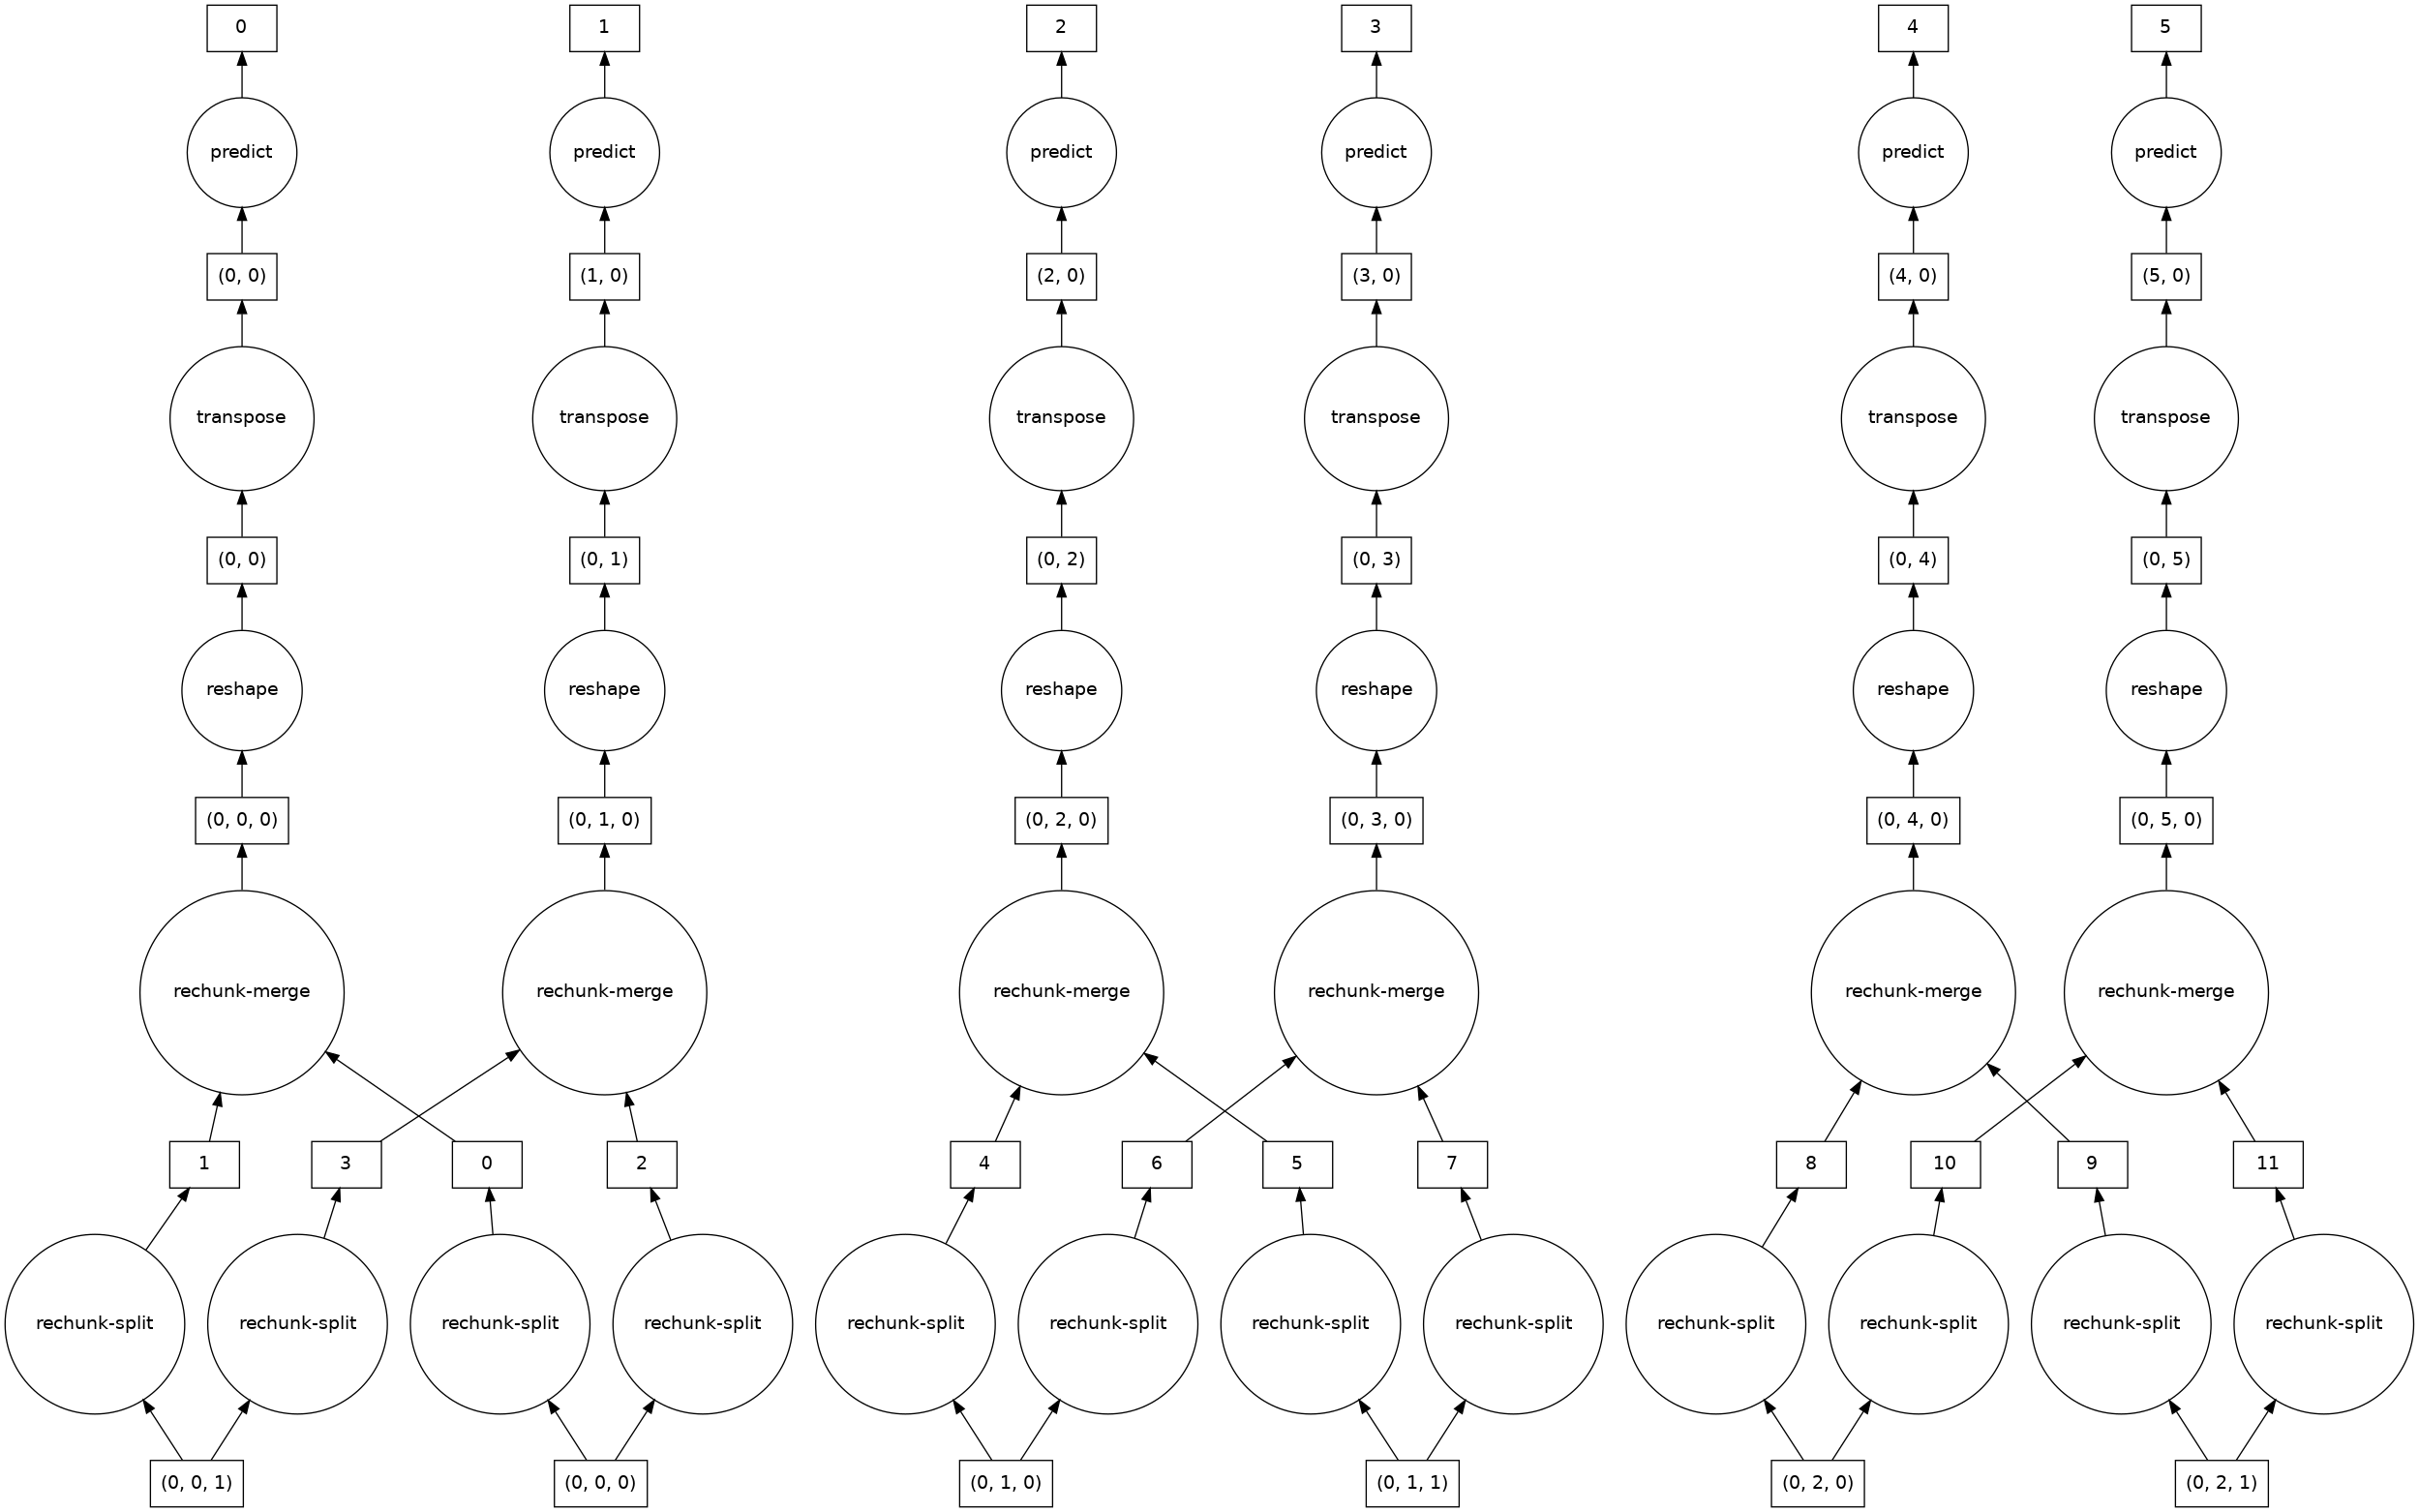

In [15]:
scene_preds.visualize()

In [16]:
# takes 10 minutes
t0 = time.time()
preds = scene_preds.compute()
print(time.time()-t0)

-624.1050906181335


In [18]:
preds

dask.array<_predict, shape=(131184400,), dtype=int64, chunksize=(30465920,), chunktype=numpy.ndarray>